### Fraud detection with Creditcard Dataset Notebook
This notebook explores the application of machine learning techniques to the Creditcard dataset, a popular dataset in machine learning, particularly for fraud detection tasks. Credit card fraud poses a significant threat to financial institutions and individuals alike, resulting in substantial financial losses and eroded trust. Traditional rule-based systems often struggle to keep pace with the evolving tactics of fraudsters, making machine learning-based anomaly detection a vital tool.

The dataset was collected during a two-day period and anonymized using Principal Component Analysis (PCA) to protect cardholder identities. It provides a realistic scenario for developing and evaluating fraud detection algorithms.

The dataset includes the following features:

- Time: Number of seconds elapsed between each transaction and the first transaction in the dataset.
- V1 - V28: Anonymized features obtained through PCA transformation. These represent various transaction attributes but their specific meanings are not provided to maintain confidentiality.
- Amount: Transaction amount.
- Class: Binary label indicating whether the transaction is fraudulent (1) or not (0). While we'll use this for evaluation, our unsupervised models will not be trained using this label.

Throughout this notebook, we will use HeatWave AutoML to train an unsupervised anomaly detection model. In this context, "unsupervised" signifies that we'll be training our models without explicitly using the "Class" label (fraudulent or legitimate) during the training phase. Instead, we'll rely on the inherent patterns and structures within the transaction data to identify deviations from the norm.

### Prerequistises
Install the necessary packages

- mysql-connector-python
- pandas 
- scikit-learn
- sqlalchemy

In [1]:
import json
import os
import mysql.connector
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import sqlalchemy
import rdata

### Connect to the HeatWave instance
We create a connection to an active [HeatWave](https://www.oracle.com/mysql/) instance using the [MySQL Connector/Python](https://dev.mysql.com/doc/connector-python/en/). We also define an API to execute a SQL query using a cursor, and the result is returned as a Pandas DataFrame. Modify the below variables to point to your HeatWave instance. On AWS, set USE_BASTION to False. On OCI, please create a tunnel on your machine using the below command by substituting the variable with their respective values.

ssh -o ServerAliveInterval=60 -i BASTION_PKEY -L LOCAL_PORT:DBSYSTEM_IP:DBSYSTEM_PORT BASTION_USER@BASTION_IP

In [ ]:
BASTION_IP = "ip_address"
BASTION_USER = "opc"
BASTION_PKEY = "private_key_file"
DBSYSTEM_IP = "ip_address"
DBSYSTEM_PORT = 3306
DBSYSTEM_USER = "username"
DBSYSTEM_PASSWORD = "password"
DBSYSTEM_SCHEMA = "ml_benchmark"
LOCAL_PORT = 31231
USE_BASTION = True

if USE_BASTION is True:
    DBSYSTEM_IP = "127.0.0.1"
else:
    LOCAL_PORT = DBSYSTEM_PORT

mydb = mysql.connector.connect(
    host=DBSYSTEM_IP,
    port=LOCAL_PORT,
    user=DBSYSTEM_USER,
    password=DBSYSTEM_PASSWORD,
    database=DBSYSTEM_SCHEMA,
    allow_local_infile=True,
    use_pure=True,
    autocommit=True,
)
mycursor = mydb.cursor()


# Helper function to execute SQL queries and return the results as a Pandas DataFrame
def execute_sql(sql: str) -> pd.DataFrame:
    mycursor.execute(sql)
    return pd.DataFrame(mycursor.fetchall(), columns=mycursor.column_names)

 ### Download the Creditcard dataset and load it into Python
 We download the creditcard dataset, and load into Python using Pandas. Given the size of the dataset (~280K rows), we take a 10% uniform random sample of the dataset for the purpose of this notebook.

In [3]:
# Download the creditcard dataset to a local folder
!wget http://www.ulb.ac.be/di/map/adalpozz/data/creditcard.Rdata
# Create a Pandas dataframe from the data
result = rdata.read_rda('creditcard.Rdata')
df = result["creditcard"]

df["Time"] = df["Time"].astype(int)
df["Class"] = df["Class"].astype(int)

df = df.sample(frac=0.1, random_state=1)

# Now that we have loaded the data in Python, we don't need the local files anymore
os.remove("creditcard.Rdata")

--2025-06-17 16:07:19--  http://www.ulb.ac.be/di/map/adalpozz/data/creditcard.Rdata
Resolving www.ulb.ac.be (www.ulb.ac.be)... 164.15.59.215
Connecting to www.ulb.ac.be (www.ulb.ac.be)|164.15.59.215|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.ulb.ac.be/di/map/adalpozz/data/creditcard.Rdata [following]
--2025-06-17 16:07:23--  https://www.ulb.ac.be/di/map/adalpozz/data/creditcard.Rdata
Connecting to www.ulb.ac.be (www.ulb.ac.be)|164.15.59.215|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ulb.be/di/map/adalpozz/data/creditcard.Rdata [following]
--2025-06-17 16:07:23--  https://www.ulb.be/di/map/adalpozz/data/creditcard.Rdata
Resolving www.ulb.be (www.ulb.be)... 164.15.59.215
Connecting to www.ulb.be (www.ulb.be)|164.15.59.215|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://di.ulb.ac.be/map/adalpozz/data/creditcard.Rdata [following]
--202

### Split the data into a training set and an evaluation set
In machine learning, the train-test split is a crucial technique used to evaluate the performance of a model on unseen data. It involves dividing the available dataset into two distinct subsets:   

- Training set: This subset is used to train the machine learning model. The model learns the underlying patterns and relationships in the data by analyzing this set.   
- Test set: This subset is held back and not used during the training process. Once the model is trained, it's applied to the test set to assess its ability to generalize to new, unseen data.

In [4]:
df_train, df_test = train_test_split(
    df, test_size=0.30, random_state=1, stratify=df["Class"]
)
df_train = df_train.replace({np.nan: "NULL"})
df_test = df_test.replace({np.nan: "NULL"})

 ### Load the Creditcard dataset into a HeatWave table
 We connect to the MySQL database using SQLAlchemy, map Pandas data types to their corresponding MySQL dialects, and writes two DataFrames (df_train and df_test) to separate tables (creditcard_train and creditcard_test) in the database, replacing any existing tables.

In [6]:
# Create a SQLAlchemy engine instance to connect to the MySQL database
sql_engine = sqlalchemy.create_engine(
    f"mysql+mysqlconnector://{DBSYSTEM_USER}:{DBSYSTEM_PASSWORD}@{DBSYSTEM_IP}:{LOCAL_PORT}/{DBSYSTEM_SCHEMA}",
    echo=False,
    echo_pool=False,
    pool_pre_ping=True,
    pool_recycle=3600,
)

# Define a dictionary mapping pandas data types to their corresponding SQLAlchemy dialects
dtype_mapping = {
    "uint64": sqlalchemy.dialects.mysql.INTEGER(unsigned=True),
    "int64": sqlalchemy.dialects.mysql.INTEGER(),
    "float64": sqlalchemy.dialects.mysql.FLOAT(),
    "object": sqlalchemy.dialects.mysql.VARCHAR(length=255),
    "datetime64[ns]": sqlalchemy.dialects.mysql.DATETIME(timezone=False),
    "bool": sqlalchemy.dialects.mysql.TINYINT(),
}
# Prepare the dtype dict for sqlalchemy/pd.DataFrame.to_sql
dtypes = {col: dtype_mapping[str(dtype)] for col, dtype in zip(df.columns, df.dtypes)}

# Write the training DataFrame to the 'creditcard_train' table in the database
df_train.to_sql(
    f"creditcard_train",
    con=sql_engine,
    if_exists="replace",
    dtype=dtypes,
    chunksize=100000,
    index=False,
)
# Write the testing DataFrame to the 'creditcard_test' table in the database
df_test.to_sql(
    f"creditcard_test",
    con=sql_engine,
    if_exists="replace",
    dtype=dtypes,
    chunksize=100000,
    index=False,
)

8545

### Create a HeatWave AutoML model from the Creditcard training dataset
We create a machine learning model on the Creditcard dataset using the ML_TRAIN API. Given this is unsupervised anomaly detection, we pass the target column name as NULL, and HeatWave AutoML builds a model learning from the patterns inherent in the data. The model learns normal and anomalous patterns in the data, allowing it to predict the same for any new data points we give it during prediction. Given that the Class target column is present in the training table, we ask ML_TRAIN to exclude it from the learned features. The model handle generated at the end of training is stored in the model variable. We will use this handle to refer to the model in our future interactions

In [7]:
execute_sql("""SET @model = NULL;""")
execute_sql(
    f"""CALL sys.ML_TRAIN('{DBSYSTEM_SCHEMA}.creditcard_train', NULL, JSON_OBJECT('task', 'anomaly_detection', 'exclude_column_list', JSON_ARRAY('Class')), @model)"""
)
model = execute_sql("""SELECT @model;""").iloc[0][0]
execute_sql(f"""CALL sys.ML_MODEL_LOAD('{model}', NULL)""")

/var/folders/10/ptwbrcrx57g8d9yqgv5n4kym0000gn/T/ipykernel_15657/2843383838.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model = execute_sql("""SELECT @model;""").iloc[0][0]


""


### Evaluate the model
We look at the overall performance of the model on unseen data by using the ML_SCORE routine to compute the accuracy. The roc_auc metric for anomaly detection tells us how well the model can separate the normal transactions from the fraudulent ones. 

In [8]:
execute_sql(
    f"""CALL sys.ML_SCORE('{DBSYSTEM_SCHEMA}.creditcard_test', 'Class', '{model}', 'roc_auc', @score, NULL);"""
)
score = execute_sql("""SELECT @score;""").iloc[0][0]
print(f"The model roc_auc is {score*100:.2f}")

The model roc_auc is 90.89


/var/folders/10/ptwbrcrx57g8d9yqgv5n4kym0000gn/T/ipykernel_15657/3390842446.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  score = execute_sql("""SELECT @score;""").iloc[0][0]


### Generating predictions to evaluate model performance on unseen test data
We invoke the ML_PREDICT_TABLE API to generate prediction for the above model on our test data. The output table contains an extra columns 
- ml_results: This contains more details about the prediction

In [9]:
execute_sql(f"""DROP TABLE IF EXISTS creditcard_test_predictions""")
execute_sql(
    f"""CALL sys.ML_PREDICT_TABLE('{DBSYSTEM_SCHEMA}.creditcard_test', '{model}', '{DBSYSTEM_SCHEMA}.creditcard_test_predictions', NULL)"""
)
df_predictions = execute_sql(f"""SELECT * FROM creditcard_test_predictions""")
execute_sql(f"""DROP TABLE IF EXISTS creditcard_test_predictions""")
df_predictions.head()

,_4aad19ca6e_pk_id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,ml_results
0,1,74165,-0.640130,1.071570,1.567180,-0.465824,0.524486,-0.583895,0.863141,-0.027511,...,-0.497223,-0.069171,0.043782,-0.194982,-0.030511,0.063452,0.114042,1.98,0,"{""predictions"": {""is_anomaly"": 0}, ""probabilit..."
1,2,94428,-1.528380,0.663147,0.723797,-0.929401,0.201948,0.265018,-0.327064,0.502370,...,-0.575276,0.346488,0.177823,-0.208438,-0.412365,-1.020960,-0.603428,0.75,0,"{""predictions"": {""is_anomaly"": 0}, ""probabilit..."
2,3,63603,0.953884,-0.806137,0.893374,0.507567,-0.624684,1.480100,-0.947183,0.500033,...,0.498213,0.050181,-0.629201,0.156014,-0.123095,0.139624,0.035701,77.50,0,"{""predictions"": {""is_anomaly"": 0}, ""probabilit..."
3,4,131607,1.982120,-0.480906,-0.244874,0.530465,-0.903423,-0.571166,-0.712471,0.037086,...,0.740551,0.149486,-0.023996,-0.152971,-0.204766,0.038112,-0.041162,1.00,0,"{""predictions"": {""is_anomaly"": 0}, ""probabilit..."
4,5,66478,-0.659545,0.401359,2.268490,1.212650,-0.359718,1.342370,-0.322820,0.637867,...,0.576824,0.019912,-0.314671,-0.640162,-0.285855,0.109475,0.150849,34.50,0,"{""predictions"": {""is_anomaly"": 0}, ""probabilit..."


### Getting a deeper understanding of the model's predictions

A [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix) in anomaly detection, while similar to its use in classification, needs a slightly different interpretation due to the often highly imbalanced nature of anomaly datasets. Here's a breakdown:

In anomaly detection, we typically have two classes:

- Normal (Negative): The majority class, representing typical, expected data.
- Anomaly (Positive): The minority class, representing unusual or unexpected data points.

The confusion matrix helps us understand how well our anomaly detection model performs by showing us how many data points were correctly and incorrectly classified. Here 0 means a normal transaction, and 1 means a fradulent transaction. Based on the diagram below, out of the 15 actual anomalies, we correctly labeled 7 of them as anomalies. We also marked 76 normal transcations as anomalies, which are our false positives.

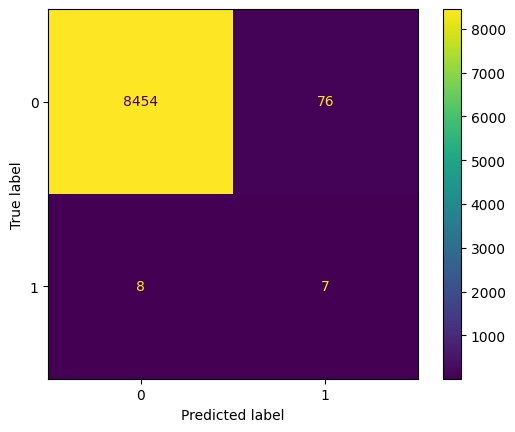

In [ ]:
ConfusionMatrixDisplay.from_predictions(
    df_predictions["Class"],
    df_predictions["ml_results"]
    .apply(json.loads)
    .apply(lambda x: x["predictions"]["is_anomaly"]),
)

We invite you to try [HeatWave AutoML and GenAI](https://www.oracle.com/heatwave/free/). If you’re new to Oracle Cloud Infrastructure, try Oracle Cloud Free Trial, a free 30-day trial with US$300 in credits.